<a href="https://colab.research.google.com/github/sakshimohta/fake_news_detection/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
!pip install ipywidgets


In [65]:
!pip install transformers

In [66]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [67]:
import numpy as np
import pandas as pd
import os
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import indian
nltk.download('indian')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
import re
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Package indian is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [69]:
df = pd.read_csv('/content/news_dataset.csv')
df.head()

label                                               text
0  REAL  Payal has accused filmmaker Anurag Kashyap of ...
1  FAKE  A four-minute-long video of a woman criticisin...
2  FAKE  Republic Poll, a fake Twitter account imitatin...
3  REAL  Delhi teen finds place on UN green list, turns...
4  REAL  Delhi: A high-level meeting underway at reside...

In [70]:
df = df.dropna()

In [71]:
df.head()

label                                               text
0  REAL  Payal has accused filmmaker Anurag Kashyap of ...
1  FAKE  A four-minute-long video of a woman criticisin...
2  FAKE  Republic Poll, a fake Twitter account imitatin...
3  REAL  Delhi teen finds place on UN green list, turns...
4  REAL  Delhi: A high-level meeting underway at reside...

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3721 entries, 0 to 3728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3721 non-null   object
 1   text    3721 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<Axes: xlabel='count', ylabel='label'>

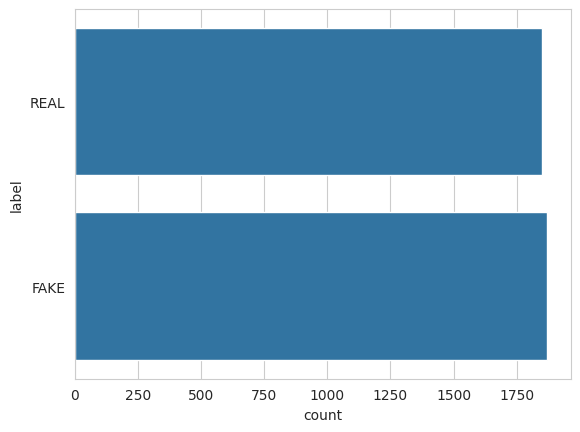

In [73]:
label = df['label']
sns.set_style('whitegrid')
sns.countplot(label)

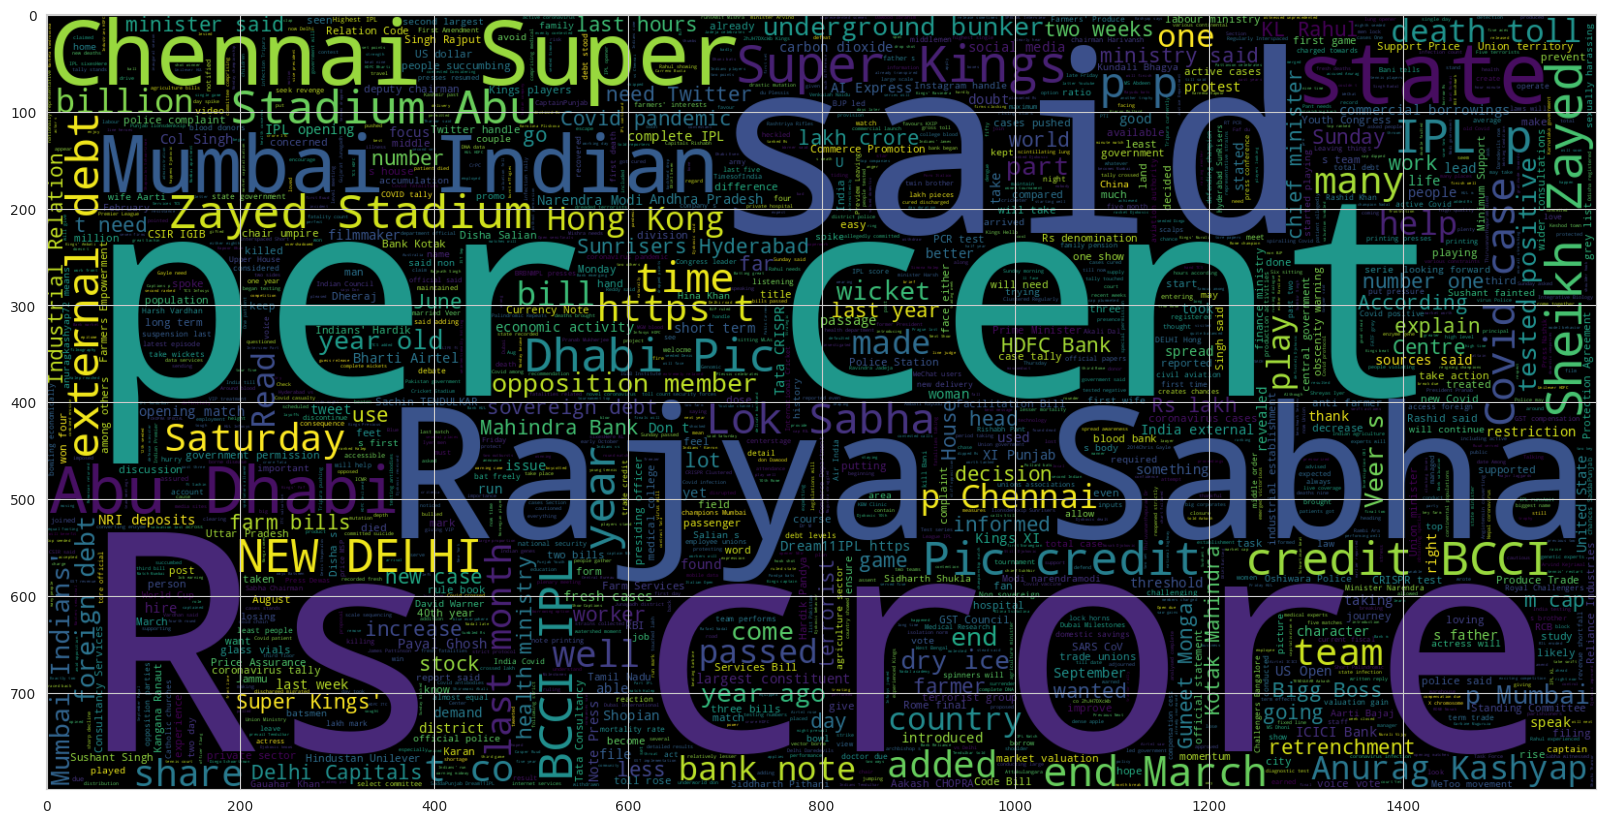

In [74]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 'REAL'].text))
plt.imshow(wc, interpolation = 'bilinear')

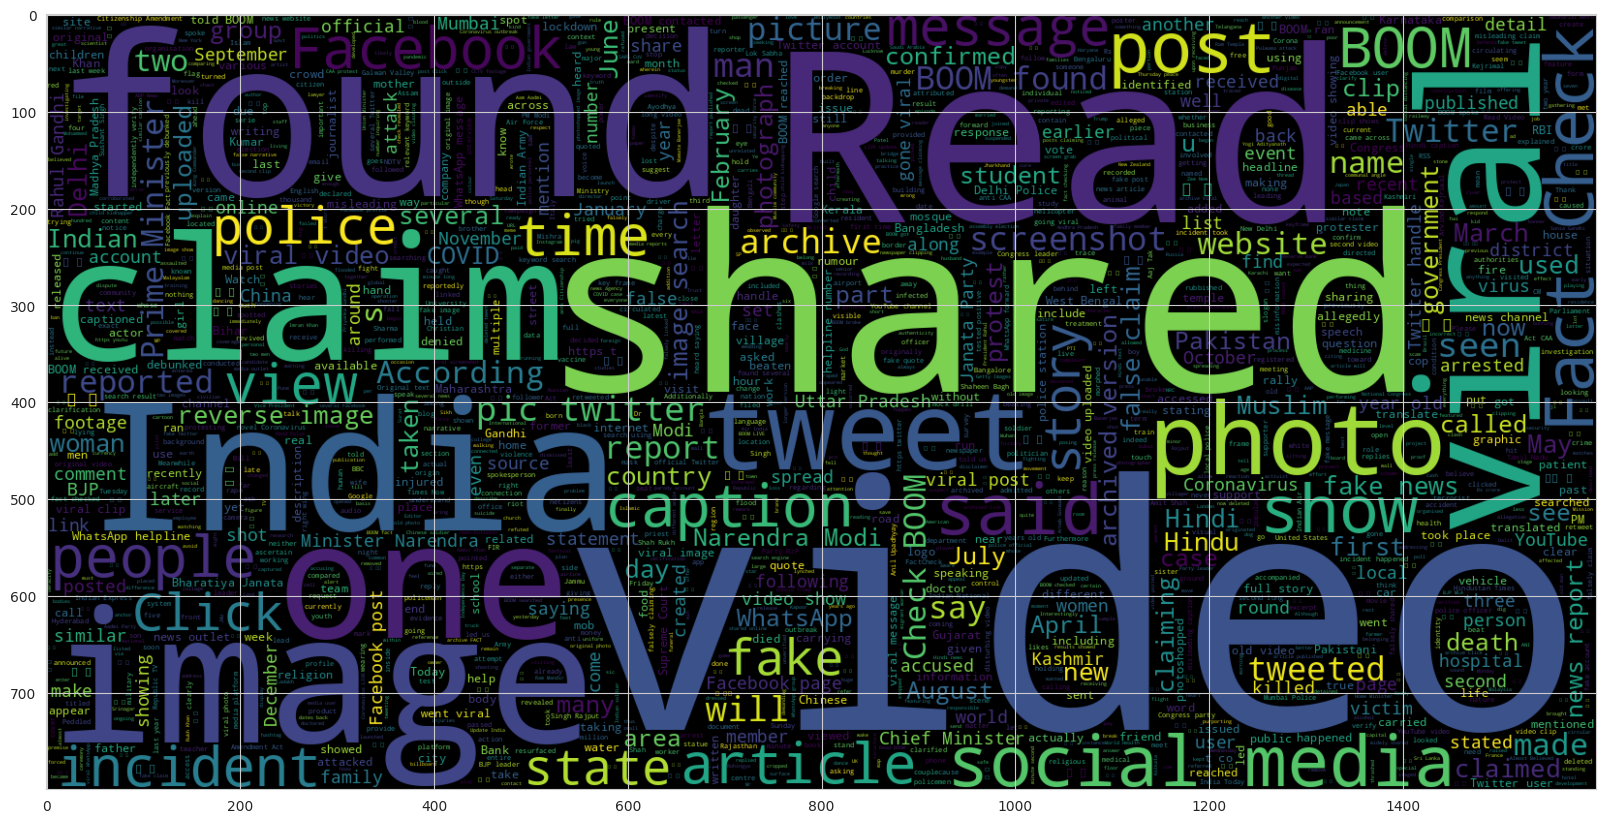

In [75]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 'FAKE'].text))
plt.imshow(wc, interpolation = 'bilinear')

In [76]:
df.label = pd.Categorical(df.label)

In [77]:
df['label'] = df.label.cat.codes

In [78]:
df.reset_index(inplace=True)

In [79]:
df = df.drop(['index'],axis=1)

In [80]:
def clean_text(text):
  text = text.lower()
  text = text.strip()
  text = re.sub('\n','',text)
  text = re.sub('\'','',text)
  text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text)
  text = re.sub('|','',text)
  text = re.sub('/','',text)
  text = re.sub('`','',text)
  text = re.sub('"','',text)
  text = re.sub("'",'',text)
  text = re.sub('!','',text)
  text = re.sub(',','',text)
  text = re.sub(':','',text)
  text = re.sub(r"[\([{})\]]", "", text)
  text = re.sub('<','',text)
  text = re.sub('>','',text)
  text = re.sub('-',' ',text)
  text = text.replace('?','')
  text = text.replace('*','')
  text = text.replace('|',' ')
  return text

In [81]:
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in (set(stopwords.words('english')) or set(nltk.corpus.indian.words('hindi.pos'))):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

In [82]:
def cleaning(text):
  text = clean_text(text)
  text = remove_stopwords_and_lemmatization(text)
  return text

In [83]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [62]:
df['text'] = df['text'].apply(cleaning)

In [84]:
max_len=128
data_text=df["text"]
data_label=df["label"]

In [85]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [86]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state = 42,shuffle=True)

In [88]:
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 128,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'np',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [89]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [90]:
maxlen = 128

In [91]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

In [105]:
model = create_model()

In [103]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    # Wrap the bert_model call in a Lambda layer to convert Keras tensors to TensorFlow tensors
    # Specify output_shape for the Lambda layer
    bert_layer = tf.keras.layers.Lambda(lambda x: bert_model(x)[1], output_shape=(768,))(
        [input_ids, input_mask]
    )
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

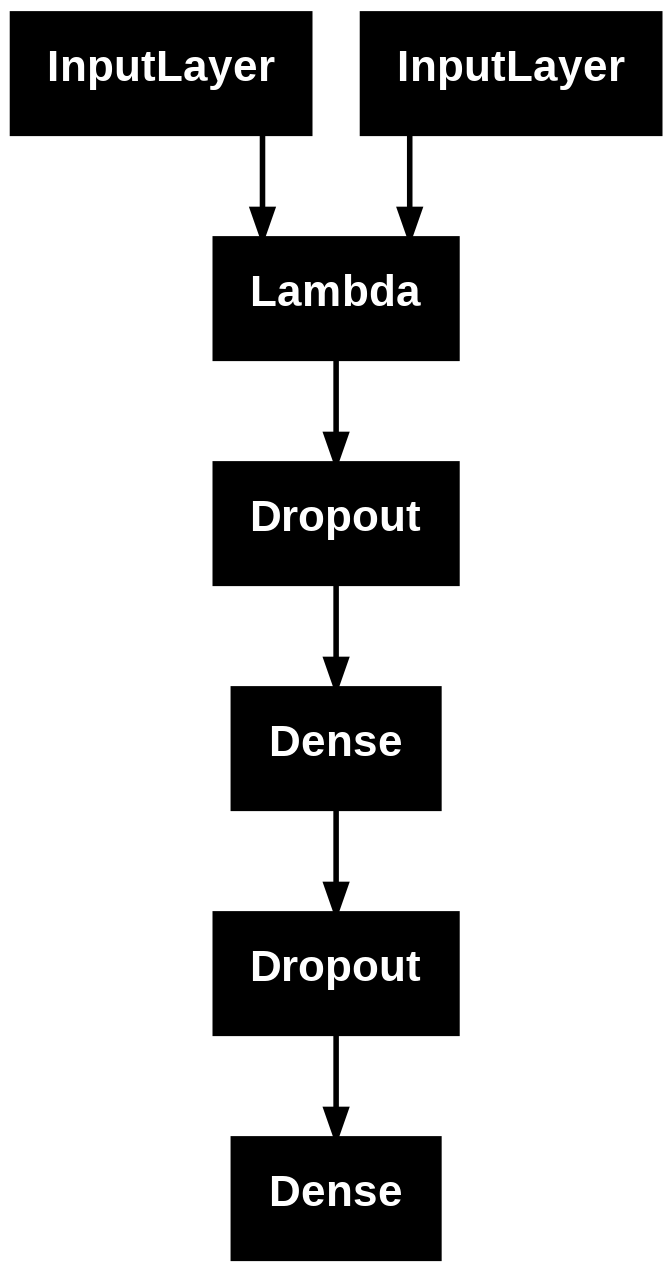

In [106]:
tf.keras.utils.plot_model(model)

In [108]:
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
# Pass 'accuracy' as a list element for the metrics argument.
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [121]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32, name='input_1')
    input_mask=Input(shape=(maxlen,),dtype=tf.int32, name='input_2')
    bert_layer = tf.keras.layers.Lambda(lambda x: bert_model(x)[1], output_shape=(768,))(
        [input_ids, input_mask]
    )
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

In [114]:
import pickle

In [115]:
filename = 'bert.pkl'
pickle.dump(model,open(filename,'wb'))

In [119]:
model = create_model()

optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 530ms/step - accuracy: 0.5371 - loss: 0.7096 - val_accuracy: 0.5671 - val_loss: 0.6755
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 323ms/step - accuracy: 0.5067 - loss: 0.7150 - val_accuracy: 0.6560 - val_loss: 0.6694
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 396ms/step - accuracy: 0.5946 - loss: 0.6850 - val_accuracy: 0.6544 - val_loss: 0.6636
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 329ms/step - accuracy: 0.5467 - loss: 0.6960 - val_accuracy: 0.6611 - val_loss: 0.6588
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.5831 - loss: 0.6817 - val_accuracy: 0.6812 - val_loss: 0.6541


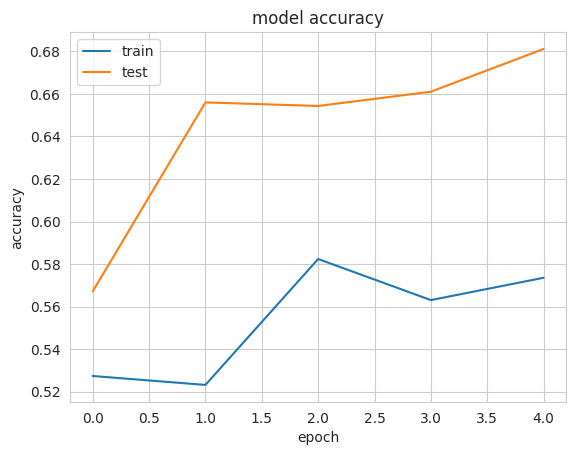

In [120]:
# Assuming you have your training data in X_train_token and Y_train:
history = model.fit(
    x = {
        'input_1': X_train_token['input_ids'],
        'input_2': X_train_token['attention_mask']
    },
    y = Y_train,
    batch_size = 32,
    epochs = 5, # Adjust the number of epochs as needed
    validation_split = 0.2 # Adjust the validation split as needed
)

# Now you can plot the training history:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

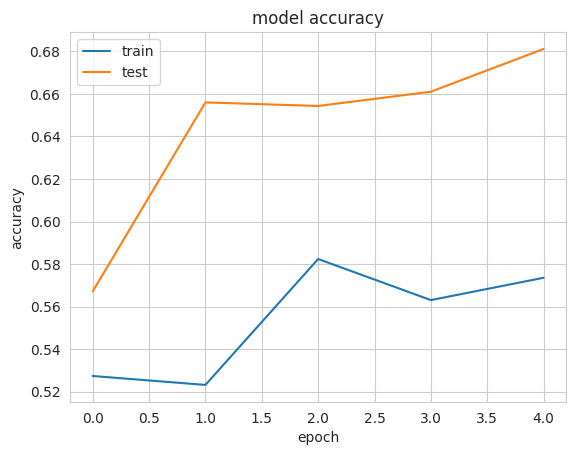

In [122]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

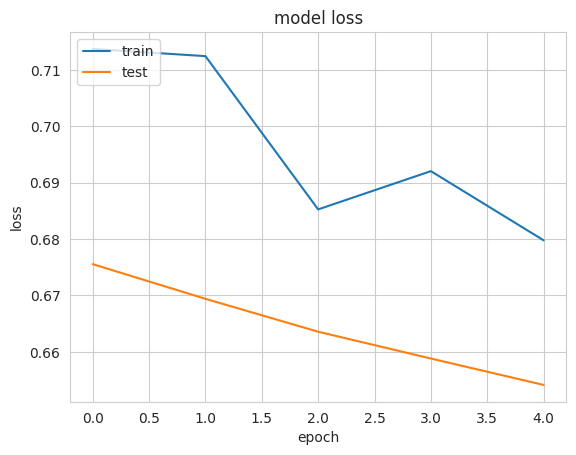

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [124]:
y_pred = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step


In [125]:
y_pred.shape

(745, 1)

In [126]:
accuracy_score(y_pred,Y_test)

0.7315436241610739

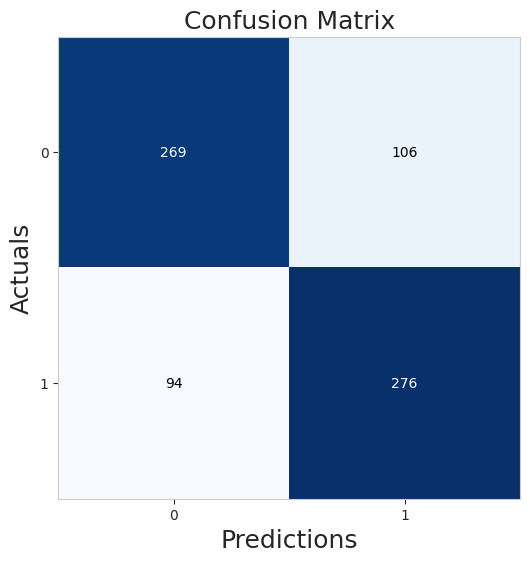

In [127]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [128]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       375
           1       0.72      0.75      0.73       370

    accuracy                           0.73       745
   macro avg       0.73      0.73      0.73       745
weighted avg       0.73      0.73      0.73       745



In [129]:
test_text = 'मध्यप्रदेश के कूनो नेशनल पार्क के बड़े बाड़े में छोडे़ जाने के बाद अफ्रीकी चीतों ने खुद पहली बार शिकार किया। दोनों चीतों ने करीब 48 घंटे बाद एक चीतल का शिकार किया। कूनो नेशनल पार्क प्रबंधन ने सोमवार को इसकी जानकारी दी। पार्क प्रबंधन ने बताया कि दोनों चीते स्वस्थ हैं। वे बड़े बाड़े में घूम रहे हैं। डीएफओ प्रकाश वर्मा ने बताया कि कॉलर आईडी, सीसीटीवी और ट्रैप कैमरों से टीम लगातार उन पर नजर रख रही है। अफ्रीका के नामीबिया से 17 सितंबर को 8 चीते कूनो नेशनल पार्क लाए गए थे। PM नरेंद्र मोदी ने इन्हें छोटे बाड़े में छोड़ा था। यहां चीतों को क्वारंटाइन किया गया था। इसके करीब 50 दिन बाद शनिवार को दो नर चीतों को बड़े बाड़े में छोड़ा गया था। दोनों चीतों को बड़े बाड़े में छोड़ने से पहले चीता टास्क फोर्स की बैठक हुई। टास्क फोर्स के सदस्यों की सहमति के बाद चीतों को छोड़ा गया था। खुद पेट भर सकेंगे चीते डीएफओ वर्मा ने बताया कि, लंबे अरसे के बाद देश की धरती पर लाए गए चीतों ने पहली बार शिकार किया है। अब वह खुद पसंदीदा जानवर का शिकार करके खुद अपना पेट भर सकेंगे। छह अन्य चीतों को रिलीज करने का निर्णय चीता टास्क फोर्स करेगा। हमारी तैयारियां पूरी हैं। यह भी पढ़ें कूनो में दो बड़े बाड़े में छोड़ा, पीएम मोदी बोले -ग्रेट न्यूज'

In [130]:
test_token = tokenize(test_text)

In [131]:
test_text_pred = np.where(model.predict({ 'input_1' : test_token['input_ids'] , 'input_2' : test_token['attention_mask']}) >=0.5,1,0)

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step


In [132]:
if(test_text_pred[0]==0):
    print("News is Fake")
else:
    print("News is Real")

News is Real


In [133]:
test1 = X_test[624]

In [134]:
test1_token = tokenize(test1)

In [135]:
def predict_probab(STR):
    z = bert_tokenizer.encode_plus(STR, add_special_tokens = True, max_length = 128, truncation = True,padding = 'max_length', return_token_type_ids=False, return_attention_mask = True,  return_tensors = 'np')
    inputs = [z['input_ids'], z['attention_mask']]
    k = []
    k.append(float(model.predict(inputs).reshape(-1,1)))
    k.append(float(1-model.predict(inputs).reshape(-1,1)))
    k = np.array(k).reshape(1,-1)

    return k

In [139]:
!pip install lime
from lime.lime_text import LimeTextExplainer

# Assuming you want to explain the predictions for binary classification (0 or 1)
class_names = [0, 1]

# Initialize the explainer
explainer = LimeTextExplainer(class_names=class_names)

# Now you can use the explainer:
exp = explainer.explain_instance(test1, predict_probab, num_features=100, num_samples=1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bc0b6581d6a690de3e22ee857ca4da11a1561454c700ac51705de664ddfb201f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [140]:
exp = explainer.explain_instance(test1,predict_probab,num_features=100,num_samples=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [141]:
exp.show_in_notebook(text=test1)